In [24]:
import os
import warnings
import importlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from astropy.io import ascii, fits
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import evaluation.evaluation_utils as evaluation_utils
from evaluation.calculate_completeness_fraction import validation_hist
from evaluation.cross_match_catalogs import read_catalog, match_catalogs_img

importlib.reload(evaluation_utils)
%matplotlib inline

In [7]:
chip_label = "07"
pointing_label = "MSC_0000000"

fig_root_dir = "./fig_for_demonstration"
if not os.path.exists(fig_root_dir):
    os.makedirs(fig_root_dir)
    
l1_img_dir = "/public/home/fangyuedong/project/demo_csst_injection/L1_products/50sqDeg_Photo_W2/%s/"%(pointing_label)
l1_injected_dir = "/public/home/fangyuedong/project/demo_csst_injection/50sqDeg_Photo_W2/%s"%(pointing_label)

# Visualize the injection
Use evaluation.evaluation_utils.plot_injection_comparison to plot before vs after injection, and the difference

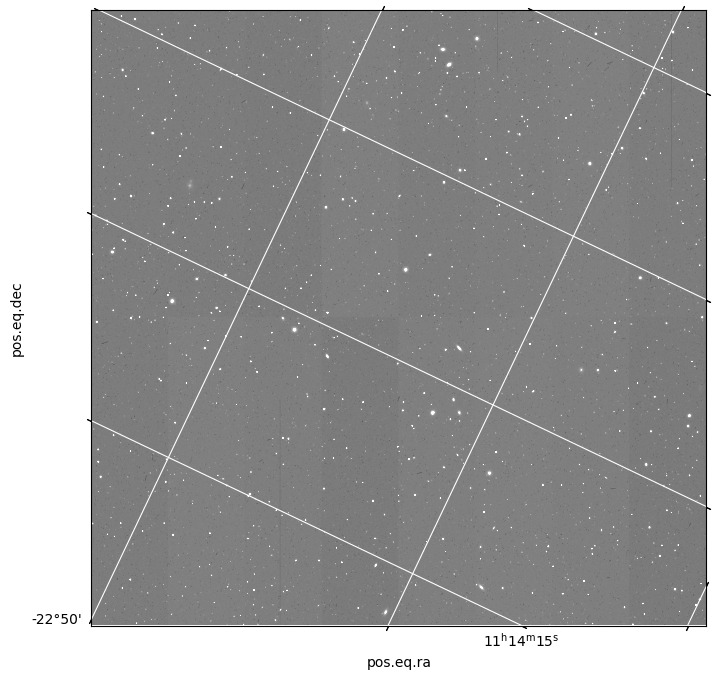

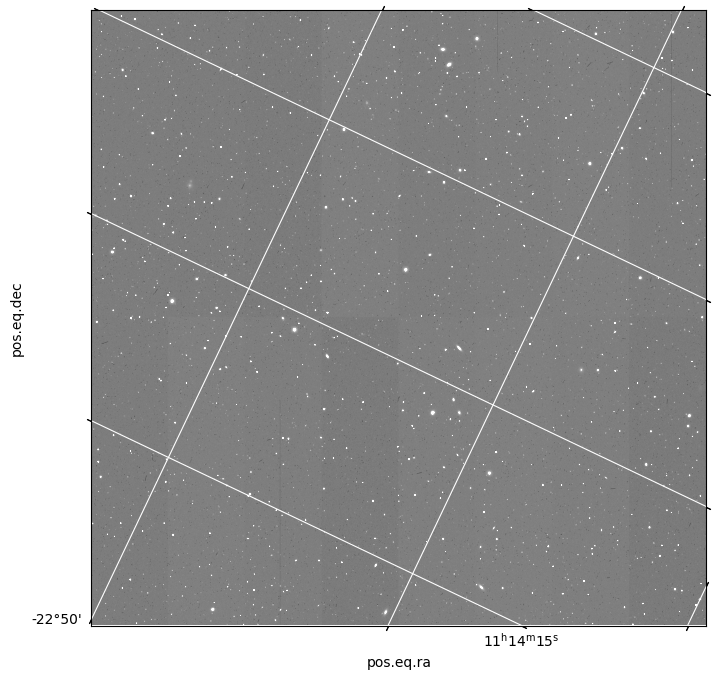

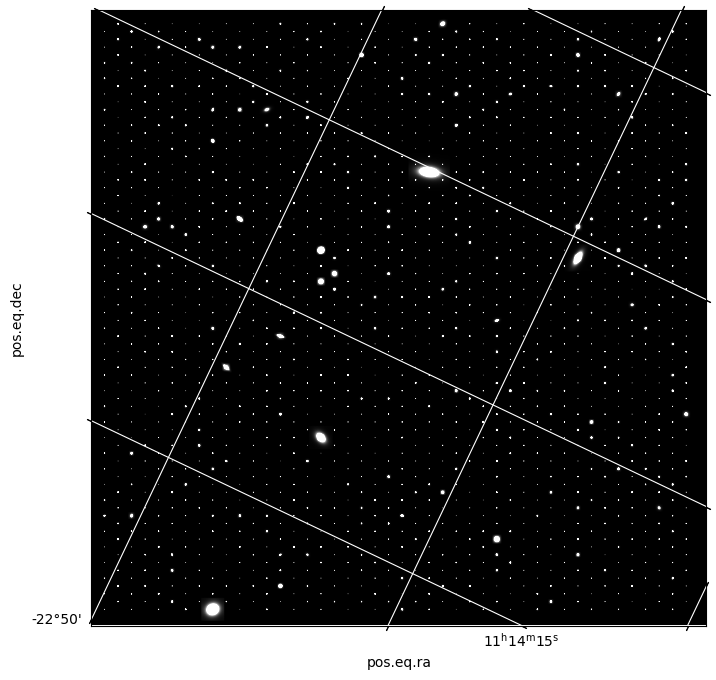

In [25]:
l1_img = glob(l1_img_dir + "/*_%s_img*.fits"%(chip_label))[0]
l1_flg = glob(l1_img_dir + "/*_%s_flg*.fits"%(chip_label))[0]
injected_img = glob(l1_injected_dir + "/*_%s_img_*.fits"%(chip_label))[0]

evaluation_utils.plot_injection_comparison(orig_img=l1_img,
                         injected_img=injected_img,
                         flg_img=l1_flg,
                         save_fig_dir=fig_root_dir,
                         fig_prefix="%s_%s_%s_"%("demo", pointing_label, chip_label),
                         figsize=(8, 8))

# Matching catalogs and check detection completeness
* For each pair of ground truth and detected catalogs from an injected image, use ```evaluation.cross_match_catalogs.match_catalogs_img``` to match the source by image coordinate
* Use ```evaluation.evaluation_utils.validation_hist``` to make a histogram for each pair. Accumulate the counts
* Use ```evaluation.evaluation_utils.create_fraction_figure``` to generate the final detection fraction histogram

Injected truth catalog:  CSST_MSC_MS_SCIE_20220708044845_20220708045115_10160000000_07_img_L1_injected.cat
L1 processed photometry catalog:  CSST_MSC_MS_SCIE_20220708044845_20220708045115_10160000000_07_cat_L1_injected.fits
number of matched sources =  389


/public/home/fangyuedong/.local/lib/python3.11/site-packages/csst_source_injection-1.0.0-py3.11.egg/evaluation/evaluation_utils.py:109: RuntimeWarning: invalid value encountered in divide
  fraction = counts_detected / counts


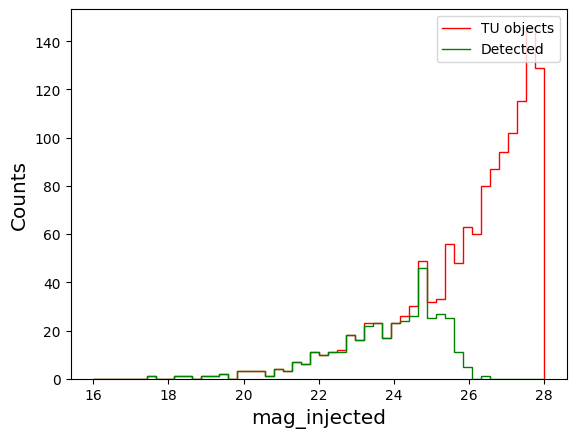

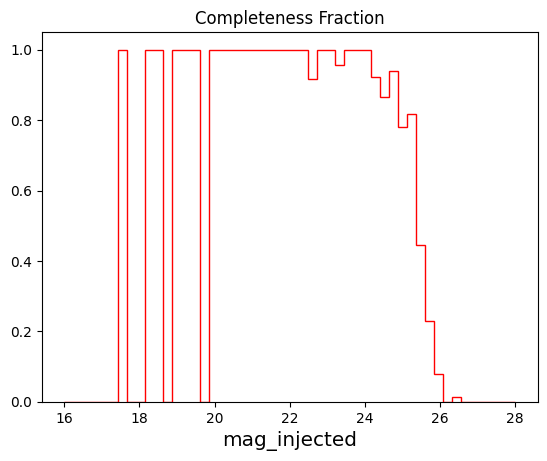

In [27]:
injected_truth_dir = "/public/home/fangyuedong/project/demo_csst_injection/50sqDeg_Photo_W2/"
injected_l1_output_dir = "/public/home/fangyuedong/project/demo_csst_injection/50sqDeg_Photo_W2/"

nbins = 50
bins = np.linspace(16., 28., nbins+1)

counts = np.zeros(nbins)
counts_detected = np.zeros(nbins)

cat_path_list_injected_truth = glob(injected_truth_dir + "*/*_%s_*.cat*"%(chip_label))
cat_path_list_injected_l1 = glob(injected_l1_output_dir + "*/*%s_cat*"%(chip_label))

for cat_path_injected_truth in cat_path_list_injected_truth:
    print("Injected truth catalog: ", os.path.basename(cat_path_injected_truth))
    obs_id = cat_path_injected_truth.split('/')[-2]
    data = ascii.read(cat_path_injected_truth)
    x_truth = data["xImage"]
    y_truth = data["yImage"]
    mag_truth = data["mag"]
    
    cat_path_injected_l1 = os.path.join(injected_l1_output_dir,
                                        obs_id,
                                        os.path.basename(cat_path_injected_truth).replace("img", "cat").replace(".cat", ".fits"))
    print("L1 processed photometry catalog: ", os.path.basename(cat_path_injected_l1))
    hdu = fits.open(cat_path_injected_l1)
    x_measure = hdu[1].data["X"]
    y_measure = hdu[1].data["Y"]
    mag_measure = hdu[1].data["Mag_Kron"]
    
    idx1, _, = match_catalogs_img(x1=x_truth, y1=y_truth, x2=x_measure, y2=y_measure)
    
    counts_temp, counts_detected_temp, _ = evaluation_utils.validation_hist(val=mag_truth, 
                                                           idx=idx1, 
                                                           name="mag_injected", 
                                                           bins=bins, 
                                                           output_dir='./', 
                                                           create_figure=False)
    counts += counts_temp
    counts_detected += counts_detected_temp
    
fig1, ax1 = evaluation_utils.create_hist_figure(counts, counts_detected, bins, "mag_injected", './')
fig1.savefig(os.path.join(fig_root_dir, "detection_recovered_W2.png"))
fig1
fig2, ax2, fraction = evaluation_utils.create_fraction_figure(counts, counts_detected, bins, 'mag_injected', './', label="W2")

# Evaluate recovered photometry
* Use ```evaluation.evaluation_utils.plot_mag_comparison``` to make diff(mag) vs true_mag plot

Injected truth catalog:  CSST_MSC_MS_SCIE_20220708044845_20220708045115_10160000000_07_img_L1_injected.cat
L1 processed photometry catalog:  CSST_MSC_MS_SCIE_20220708044845_20220708045115_10160000000_07_img_L1_injected.cat
number of matched sources =  389


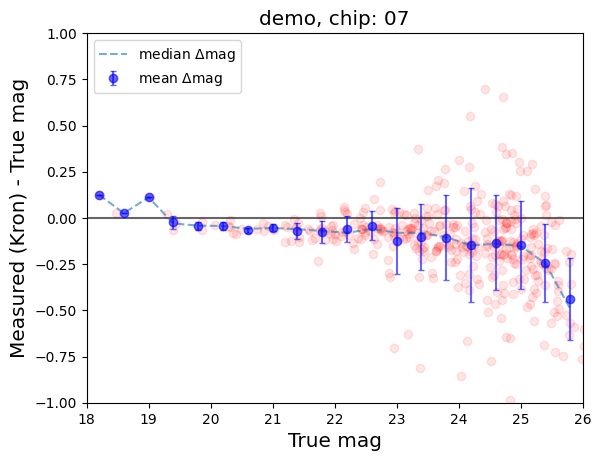

In [30]:
importlib.reload(evaluation_utils)
injected_truth_dir = "/public/home/fangyuedong/project/demo_csst_injection/50sqDeg_Photo_W2/"
injected_l1_output_dir = "/public/home/fangyuedong/project/demo_csst_injection/50sqDeg_Photo_W2/"

cat_path_list_injected_truth = glob(injected_truth_dir + "*/*_%s_*.cat*"%(chip_label))
evaluation_utils.plot_mag_comparison(truth_cat_list=cat_path_list_injected_truth,
                                    measured_cat_root_dir=injected_l1_output_dir,
                                    save_fig_dir=fig_root_dir,
                                    fig_prefix="%s_%s_"%("demo", chip_label),
                                    title="%s, chip: %s"%("demo", chip_label))